In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.qmc import LatinHypercube, Sobol
from IPython.display import display, Markdown

In [21]:
class Mandelbrot:
    """
    A class to generate and visualize the Mandelbrot set on a complex plane.

    Methods
    -------
    
    """
    def __init__(self, width, height, x_range, y_range, max_iterations):
        """
        Attributes
        ----------
        width : int
            The width (in pixels) of the output image.
        height : int
            The height (in pixels) of the output image.
        x_min : float
            The minimum value of the real axis.
        x_max : float
            The maximum value of the real axis.
        y_min : float
            The minimum value of the imaginary axis.
        y_max : float
            The maximum value of the imaginary axis.
        max_iterations : int
            The maximum number of iterations to determine if a point belongs to the Mandelbrot set.
        """

        self.width = width
        self.height = height
        self.x_min, self.x_max = x_range
        self.y_min, self.y_max = y_range
        self.max_iterations = max_iterations
        
        #meshgrid of complex numbers
        self.x_coords = np.linspace(self.x_min, self.x_max, self.width)
        self.y_coords = np.linspace(self.y_min, self.y_max, self.height)
        self.X, self.Y = np.meshgrid(self.x_coords, self.y_coords)
        self.C = self.X + 1j * self.Y
        
        #init Mandelbrot set array
        self.mandelbrot_set = np.zeros((self.height, self.width), dtype=int)
    
    def generate(self):
        """
        Computes the Mandelbrot set by iterating over each complex number in the plane.

        Returns
        -------
        mandelbrot_set : numpy.ndarray
            A 2D array where each element represents the iteration count at which the corresponding point diverged, or `max_iterations` if it is within the Mandelbrot set.
        """
        #iterate over the complex plane
        Z = np.zeros_like(self.C, dtype=np.complex128)
        iterations = np.zeros_like(self.C, dtype=int)
        
        mask = np.ones_like(self.C, dtype=bool)
        for n in range(self.max_iterations):
            Z[mask] = Z[mask]**2 + self.C[mask]
            diverged = np.abs(Z) > 2
            self.mandelbrot_set[mask & ~diverged] = n
            mask[diverged] = False
            if not np.any(mask):
                break

        return self.mandelbrot_set
        
    def is_stable(self, c, iterations):
        
        # Convert single complex number to numpy array if needed
        if isinstance(c, complex):
            c = np.array([c], dtype=np.complex128)
        
        # Initialize arrays
        z = np.zeros_like(c)
        mask = np.ones(c.shape, dtype=bool)
        
        # Iterate only on points that haven't escaped
        for _ in range(iterations):
            z[mask] = z[mask] * z[mask] + c[mask]
            mask[np.abs(z) > 2] = False
            if not np.any(mask):
                break
        
        # For single input, return scalar boolean
        if len(mask) == 1:
            return mask[0]
        return mask

    def calc_area_random_uniform(self, samples, iterations=0):
        """
        Area calculation by completely random uniform sampling.

        Definition: "In random sampling new sample points are generated without taking into account the previously generated sample points. One does not necessarily need to know beforehand how many sample points are needed." (Wikipedia)

        Attributes
        ----------
        samples : int
            Amount of points generated
        iterations : int
            Set the max iteration used to determine whether the point is in the Mandelbrot set

        Returns 
        -------
        set_area : float
            Total calculated area of the Mandelbrot set given samples and iterations.
        """
       
        # Generate all random points (LH) at once
        real = np.random.uniform(self.x_min, self.x_max,samples)
        imag = np.random.uniform(self.y_min, self.y_max,samples)
        points = real + 1j * imag
        
        # Calculate stability for all points at once
        stable_points = self.is_stable(points, iterations)
        
        # Calculate area
        total_area = (self.x_max - self.x_min) * (self.y_max - self.y_min)
        set_area = total_area * (np.sum(stable_points) / samples)
        
        return set_area
    
    def calc_area_latin_hypercube(self, samples, iterations=0):
        """
        Area calculation by latin hypercube sampling.

        Definition: "In Latin hypercube sampling one must first decide how many sample points to use and for each sample point remember in which row and column the sample point was taken. Such configuration is similar to having N rooks on a chess board without threatening each other." (Wikipedia)

        Attributes
        ----------
        samples : int
            Amount of points generated
        iterations : int
            Set the max iteration used to determine whether the point is in the Mandelbrot set

        Returns 
        -------
        set_area : float
            Total calculated area of the Mandelbrot set given samples and iterations.
        """
        # Create LHS sampler
        sampler = LatinHypercube(d=2)
        
        # Generate normalized LHS samples in [0,1]
        lhs_samples = sampler.random(n=samples)
        
        # Scale samples to desired ranges
        real = lhs_samples[:, 0] * (self.x_max - self.x_min) + self.x_min
        imag = lhs_samples[:, 1] * (self.y_max - self.y_min) + self.y_min
        
        # Calculate stability for all points at once
        points = real + 1j * imag
        stable_points = self.is_stable(points, iterations)
        
        # Calculate area
        total_area = (self.x_max - self.x_min) * (self.y_max - self.y_min)
        set_area = total_area * (np.sum(stable_points) / samples)
        
        return set_area
    
    def calc_area_orthogonal_sampling(self,samples,iterations=0):
        """
        Area calculation by orthogonal sampling.

        Definition: "In orthogonal sampling, the sample space is partitioned into equally probable subspaces. All sample points are then chosen simultaneously making sure that the total set of sample points is a Latin hypercube sample and that each subspace is sampled with the same density." (Wikipedia)

        Attributes
        ----------
        samples : int
            Amount of points generated
        iterations : int
            Set the max iteration used to determine whether the point is in the Mandelbrot set

        Returns 
        -------
        set_area : float
            Total calculated area of the Mandelbrot set given samples and iterations.
        """ 
        # Calculate grid size (try to make it as square as possible)
        n = int(np.sqrt(samples))
        if n * n < samples:
            n += 1
        
        # Create stratified grid
        x_strata = np.linspace(self.x_min, self.x_max, n)
        y_strata = np.linspace(self.y_min, self.y_max, n)
        
        # Calculate stratum sizes
        x_stratum_size = (self.x_max - self.x_min) / n
        y_stratum_size = (self.y_max - self.y_min) / n
        
        # Initialize arrays for results
        real_parts = np.zeros(n * n)
        imag_parts = np.zeros(n * n)
        
        # Generate stratified random points
        for i in range(n):
            for j in range(n):
                idx = i * n + j
                # Random point within each stratum
                real_parts[idx] = x_strata[i] + np.random.uniform(0, 1) * x_stratum_size
                imag_parts[idx] = y_strata[j] + np.random.uniform(0, 1) * y_stratum_size
        
        # Truncate to desired number of samples if necessary
        if n * n > samples:
            # Randomly select the desired number of samples
            indices = np.random.choice(n * n, samples, replace=False)
            real_parts = real_parts[indices]
            imag_parts = imag_parts[indices]
        
        # Calculate stability for all points at once
        points = real_parts + 1j * imag_parts
        stable_points = self.is_stable(points, iterations)
        
        # Calculate area
        total_area = (self.x_max - self.x_min) * (self.y_max - self.y_min)
        set_area = total_area * (np.sum(stable_points) / samples)
        
        return set_area
    
    def calc_area_antithetic(self, samples, iterations=0):
        """
        Area calculation using Antithetic Sampling.

        In Antithetic Sampling, for every random point (x, y) generated, an opposite point (-x, -y) is also considered.
        
        Attributes
        ----------
        samples : int
            Number of random points (each point will have an antithetic pair).
        iterations : int
            Maximum iterations for stability check.

        Returns
        -------
        set_area : float
            Calculated area of the Mandelbrot set using Antithetic Sampling.
        """
        # Generate random points
        real = np.random.uniform(self.x_min, self.x_max, samples)
        imag = np.random.uniform(self.y_min, self.y_max, samples)
        points = real + 1j * imag
        
        # Generate antithetic points
        antithetic_real = -real
        antithetic_imag = -imag
        antithetic_points = antithetic_real + 1j * antithetic_imag
        
        # Concatenate original and antithetic points
        all_points = np.concatenate([points, antithetic_points])
        
        # Calculate stability for all points at once
        stable_points = self.is_stable(all_points, iterations)
        
        # Calculate area
        total_area = (self.x_max - self.x_min) * (self.y_max - self.y_min)
        set_area = total_area * (np.sum(stable_points) / (2 * samples))  # Divide by 2*samples as we have double the points
        
        return set_area
    
    def calc_area_sobol(self, samples, iterations=0):
        """
        Area calculation using Sobol Quasi-Monte Carlo Sampling.

        Attributes
        ----------
        samples : int
            Number of sample points to generate (should ideally be a power of two).
        iterations : int
            Maximum iterations for stability check.

        Returns
        -------
        set_area : float
            Calculated area of the Mandelbrot set using Sobol sampling.
        """
        # Adjust `samples` to the nearest power of two if it's not already
        if not (samples & (samples - 1) == 0) and samples != 0:
            samples = 2**int(np.floor(np.log2(samples)))

        # Create a Sobol sequence sampler
        sampler = Sobol(d=2, scramble=True)
        
        # Generate Sobol samples in [0,1] and then scale to our complex plane
        sobol_samples = sampler.random_base2(m=int(np.log2(samples)))
        
        # Scale samples to desired ranges
        real = sobol_samples[:, 0] * (self.x_max - self.x_min) + self.x_min
        imag = sobol_samples[:, 1] * (self.y_max - self.y_min) + self.y_min
        
        # Combine real and imaginary parts to form complex points
        points = real + 1j * imag
        
        # Check stability of each point
        stable_points = self.is_stable(points, iterations)
        
        # Calculate the area based on the proportion of stable points
        total_area = (self.x_max - self.x_min) * (self.y_max - self.y_min)
        set_area = total_area * (np.sum(stable_points) / samples)
        
        return set_area




In [22]:
m = Mandelbrot(1000,1000,(-2.0,0.8),(-1.3,1.3),150)
m_set = m.generate()

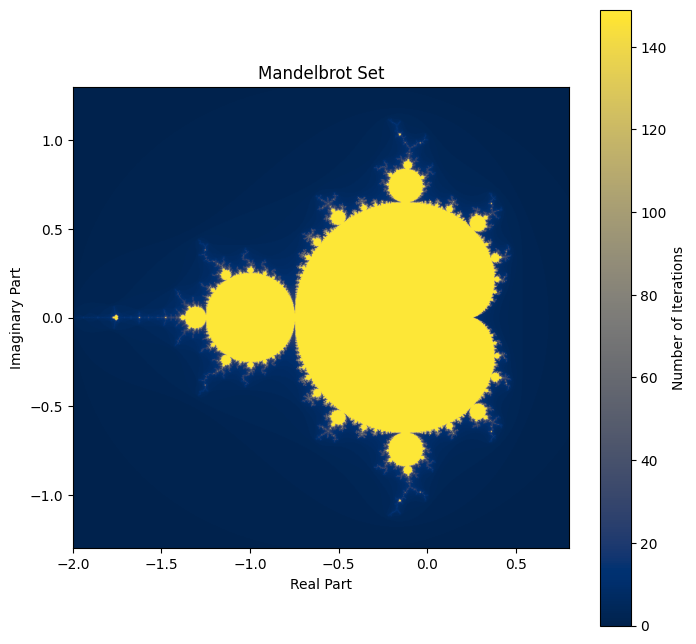

In [23]:
# Generate a nice heatmap of the data
plt.figure(figsize = (8, 8))
plt.imshow(m_set,  extent = (m.x_min, m.x_max, m.y_min, m.y_max), cmap = 'cividis')
plt.colorbar(label = 'Number of Iterations')
plt.title("Mandelbrot Set")
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.show()


In [24]:
def create_js_lists(method, steps, i_list, s_list, area):
    
    for step in range(1, steps):
        i_list.append(i_list[step - 1] + 1)

    # Define dictionary to store the estimated areas for each j, for each s
    dic_diff = {s: [] for s in s_list}

    for j in i_list:
        for s in s_list:
            diff = abs(method(s, j) - area) / area
            dic_diff[s].append(diff)
    
    return dic_diff

#DEFINE initial and fundamental variables
# Create lists of all i and s
steps = 300
i_list = [1]
s_list = [10, 50, 100, 300, 1000, 10000, 50000]

$A_{M} \cong 1.4997163999999998$

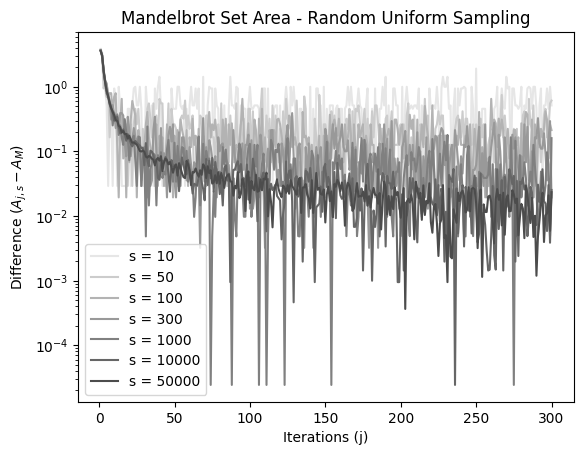

In [25]:
# Calculate an estimate of A_{M}
A_M = m.calc_area_random_uniform(200000, 10000)
display(Markdown(rf"$A_{{M}} \cong {A_M}$"))

dic_diff = create_js_lists(m.calc_area_random_uniform,steps,i_list,s_list,A_M)

# Plot the differences with A_{M} for every estimated area
for index, (s, diff) in enumerate(dic_diff.items()):
    plt.plot(i_list, diff, color = plt.cm.gray(1-(0.1 + 0.6 * (index / (len(s_list) - 1)))), label = f's = {s}')

plt.title("Mandelbrot Set Area - Random Uniform Sampling")
plt.yscale('log')
plt.xlabel('Iterations (j)')
plt.ylabel(r'Difference ($A_{j, s}-A_{M}$)')
plt.legend()
plt.show()

$A_{LHS} \cong 1.5101995999999998$

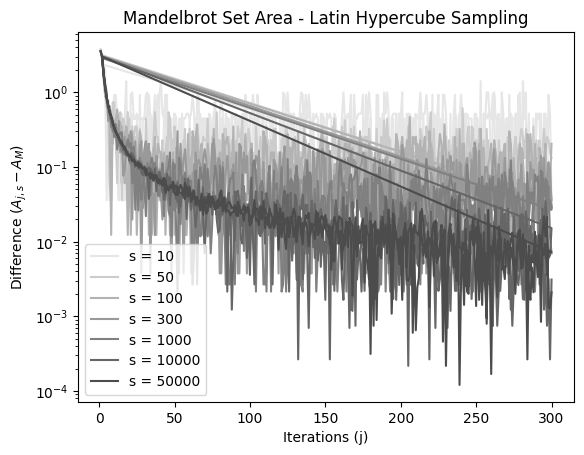

In [26]:
A_LHS = m.calc_area_latin_hypercube(200000, 10000)
display(Markdown(rf"$A_{{LHS}} \cong {A_LHS}$"))

dic_diff = create_js_lists(m.calc_area_latin_hypercube,steps,i_list,s_list,A_LHS)

# Plot the differences with A_{M} for every estimated area
for index, (s, diff) in enumerate(dic_diff.items()):
    plt.plot(i_list, diff, color = plt.cm.gray(1-(0.1 + 0.6 * (index / (len(s_list) - 1)))), label = f's = {s}')

plt.title("Mandelbrot Set Area - Latin Hypercube Sampling")
plt.yscale('log')
plt.xlabel('Iterations (j)')
plt.ylabel(r'Difference ($A_{j, s}-A_{M}$)')
plt.legend()
plt.show()

$A_{OS} \cong 1.5010268$

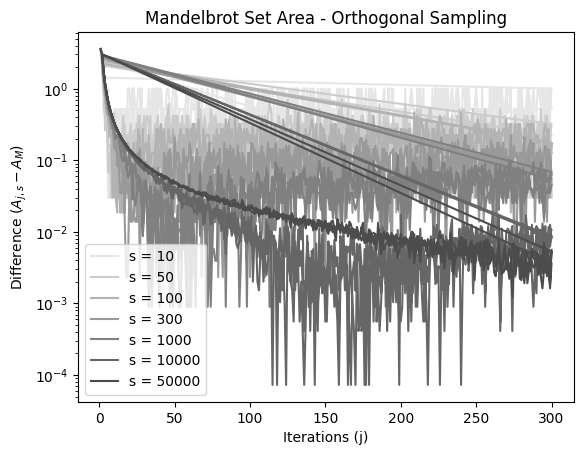

In [27]:
A_OS = m.calc_area_orthogonal_sampling(200000, 10000)
display(Markdown(rf"$A_{{OS}} \cong {A_OS}$"))

dic_diff = create_js_lists(m.calc_area_orthogonal_sampling,steps,i_list,s_list,A_OS)

for index, (s, diff) in enumerate(dic_diff.items()):
    plt.plot(i_list, diff, color = plt.cm.gray(1-(0.1 + 0.6 * (index / (len(s_list) - 1)))), label = f's = {s}')

plt.title("Mandelbrot Set Area - Orthogonal Sampling")
plt.yscale('log')
plt.xlabel('Iterations (j)')
plt.ylabel(r'Difference ($A_{j, s}-A_{M}$)')
plt.legend()
plt.show()

$A_{anti} \cong 1.4050581999999998$

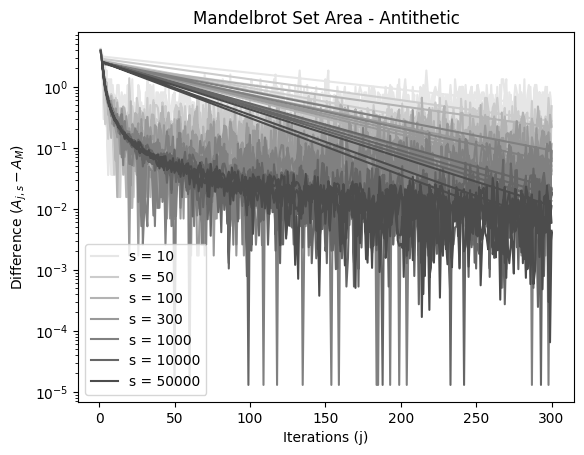

In [28]:
A_anti = m.calc_area_antithetic(200000, 10000)
display(Markdown(rf"$A_{{anti}} \cong {A_anti}$"))

dic_diff = create_js_lists(m.calc_area_antithetic,steps,i_list,s_list,A_anti)

for index, (s, diff) in enumerate(dic_diff.items()):
    plt.plot(i_list, diff, color = plt.cm.gray(1-(0.1 + 0.6 * (index / (len(s_list) - 1)))), label = f's = {s}')

plt.title("Mandelbrot Set Area - Antithetic")
plt.yscale('log')
plt.xlabel('Iterations (j)')
plt.ylabel(r'Difference ($A_{j, s}-A_{M}$)')
plt.legend()
plt.show()

$A_{sobol} \cong 1.5074096679687499$

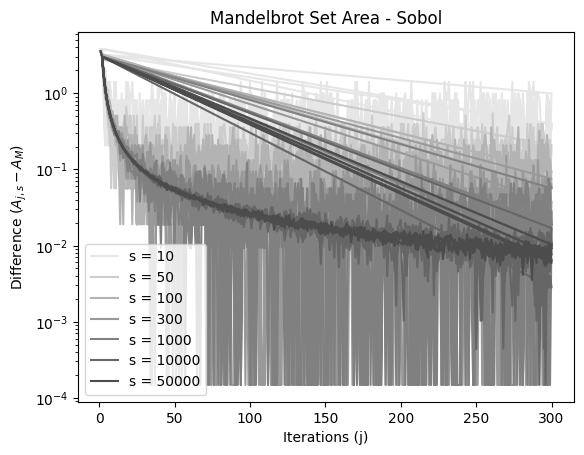

In [29]:
A_sobol = m.calc_area_sobol(200000, 10000)
display(Markdown(rf"$A_{{sobol}} \cong {A_sobol}$"))

dic_diff = create_js_lists(m.calc_area_sobol,steps,i_list,s_list,A_sobol)

for index, (s, diff) in enumerate(dic_diff.items()):
    plt.plot(i_list, diff, color = plt.cm.gray(1-(0.1 + 0.6 * (index / (len(s_list) - 1)))), label = f's = {s}')

plt.title("Mandelbrot Set Area - Sobol")
plt.yscale('log')
plt.xlabel('Iterations (j)')
plt.ylabel(r'Difference ($A_{j, s}-A_{M}$)')
plt.legend()
plt.show()